In [1]:
# we will automate the derivative that is used for back-propogation instead of calculating derivative by ourselves
# by altering the class

In [2]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
class Value:
    
    def __init__(self, data, _children=(), _op = '', label = ''):
        self.data = data
        self._prev = set(_children)
        self._op = _op
        self.label = label
        self.grad = 0.0         # initial value
        self._backward = lambda : None
    def __repr__(self):
        return f"Value(data = {self.data})"
    
    # Note:
    #out = Class(argument, (who are childrem node, again children node), 'name of operation')
    
    def __add__(self, other):
        out = Value(self.data + other.data, (self,other), '+')

        def _backward():
            self.grad = 1.0 * out.grad
            other.grad = 1.0 * out.grad
        out._backward = _backward
        return out
    
    def __sub__(self, other):
        out = Value(self.data - other.data, (self, other), '-')
        
        def _backward():
            self.grad = 1.0 * out.grad
            other.grad = -1.0 * out.grad
        out._backward = _backward
        return out
    
    def __mul__(self, other):
        out = Value(self.data * other.data, (self, other), '*')
        
        def _backward():
            self.grad = other.data * out.grad
            other.grad = self.data * out.grad
        out._backward = _backward
        return out
    
    def __truediv__(self, other):
        out = Value(self.data / other.data,  (self, other), '/')
        
        def _backward():
            self.grad = (1.0/other.data)*out.grad
            other.grad = (-1.0*self.data/(other.data**2))*out.grad
        out._backward = _backward
        return out
    
    def tanh(self):
        x = self.data
        t = (np.exp(x) - np.exp(-x))/ (np.exp(x) + np.exp(-x))
        out = Value(t, (self, ), 'tanh')
        
        def _backward():
            self.grad = (1 - t**2) * out.grad
        out._backward = _backward    
        return out
    
    def backward(self):
        
        topo = []     # empty list to be appended with the children nodes
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)       
        build_topo(self)
        
        self.grad = 1.0
        for node in reversed(topo):
            node._backward()

In [4]:
from graphviz import Digraph

def trace(root):
    # builds a set of all nodes and edges in a graph
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format = 'svg', graph_attr = {'rankdir': 'LR'})   # LR = Left to right
    
    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        # for any value in the graph, create a rectangular ('record') node for it
        dot.node(name = uid, label = "{%s | data %.4f | grad %.4f}" %(n.label ,n.data, n.grad ), shape = 'record')
        if n._op:
            # if this value is a result of some operation, create an op node for it
            dot.node(name = uid + n._op, label = n._op)
            # and connect this node to it
            dot.edge(uid + n._op, uid)
            
    for n1, n2 in edges:   
        # connect n1 to the op node of n2
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
        
    return dot

In [5]:
# Input nodes
x1 = Value(2.0, label = 'x1')
x2 = Value(0.0, label = 'x2')
# weights
w1 = Value(-3.0, label ='w1')
w2 = Value(1.0, label = 'w2')
# bias
b = Value(6.881847283479823, label = 'b')

# forward propogation of input nodes
x1w1 = x1*w1; x1w1.label = 'x1w1'
x2w2 = x2*w2; x2w2.label = 'x2w2'
x1w1x2w2 = x1w1+x2w2; x1w1x2w2.label = 'x1w1x2w2'
n = x1w1x2w2 + b; n.label = 'n'

#Since we have not tanh function in the class, we can not directly implement it,so go back and define it in class 
# done
o = n.tanh(); o.label = 'o'

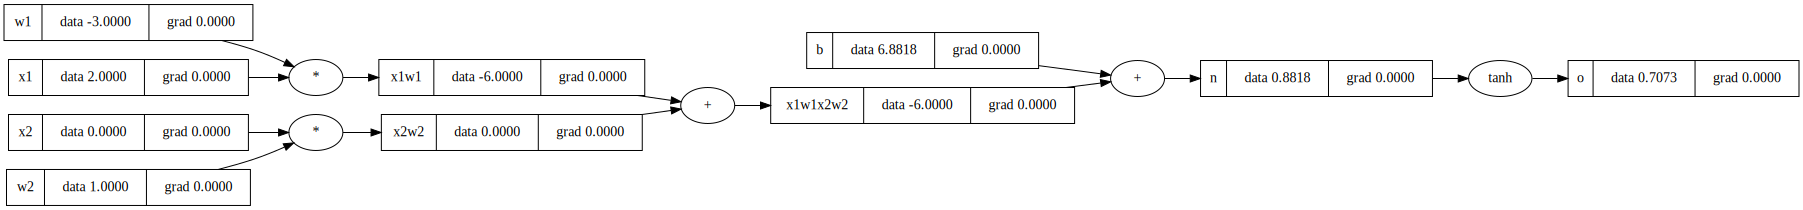

In [6]:
draw_dot(o)

In [7]:
o.backward()

In [8]:
# setting the initial out grad, such that first case wont become zero
o.grad = 1.0
'''o._backward()
n._backward()
b._backward()
x1w1x2w2._backward()
x1w1._backward()
x2w2._backward()
x1._backward()
x2._backward()
w1._backward()
w2._backward()'''

'o._backward()\nn._backward()\nb._backward()\nx1w1x2w2._backward()\nx1w1._backward()\nx2w2._backward()\nx1._backward()\nx2._backward()\nw1._backward()\nw2._backward()'

In [9]:
# But we must also remove the manual calling of _backward function of the class
# This is achieved by laying out the full map of every node before calling _backward on any of node
# achieved with topological sort
# makes edges go left to right only

#### Topological sorting for Directed Acyclic Graph (DAG) is a linear ordering of vertices such that for every directed edge u v, vertex u comes before v in the ordering.
For instance, the vertices of the graph may represent tasks to be performed, and the edges may represent constraints that one task must be performed before another; in this application, a topological ordering is just a valid sequence for the tasks. Precisely, a topological sort is a graph traversal in which each node v is visited only after all its dependencies are visited.

In [10]:
'''
topo = []     # empty list to be appended with the children nodes
visited = set()
def build_topo(v):
    if v not in visited:
        visited.add(v)
        for child in v._prev:
            build_topo(child)
        topo.append(v)       
#build_topo(x1w1x2w2)           # initiating at the root node, i.e. "o" node
# build_topo(x1w1)
build_topo(o)
topo
'''

'\ntopo = []     # empty list to be appended with the children nodes\nvisited = set()\ndef build_topo(v):\n    if v not in visited:\n        visited.add(v)\n        for child in v._prev:\n            build_topo(child)\n        topo.append(v)       \n#build_topo(x1w1x2w2)           # initiating at the root node, i.e. "o" node\n# build_topo(x1w1)\nbuild_topo(o)\ntopo\n'

In [11]:
# we have basically made list of nodes in a topological order, from left to right

In [12]:
# lets use the above topological sorted nodes
'''o.grad = 1.0
topo = []     # empty list to be appended with the children nodes
visited = set()
def build_topo(v):
    if v not in visited:
        visited.add(v)
        for child in v._prev:
            build_topo(child)
        topo.append(v)       
#build_topo(x1w1x2w2)           # initiating at the root node, i.e. "o" node
# build_topo(x1w1)
build_topo(o)
topo

for node in reversed(topo):
    node._backward()
'''
# This cell has been copied into the class and defined within backward function

'o.grad = 1.0\ntopo = []     # empty list to be appended with the children nodes\nvisited = set()\ndef build_topo(v):\n    if v not in visited:\n        visited.add(v)\n        for child in v._prev:\n            build_topo(child)\n        topo.append(v)       \n#build_topo(x1w1x2w2)           # initiating at the root node, i.e. "o" node\n# build_topo(x1w1)\nbuild_topo(o)\ntopo\n\nfor node in reversed(topo):\n    node._backward()\n'

### We have done well for the code, buit we still have a major bug
### First we will introduce the bug

#### Lets introduce the bug

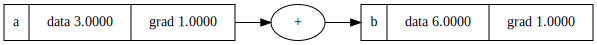

In [14]:
# the simplest case being:
a = Value(3.0, label = 'a')
b = a + a; b.label ='b'
b.backward()
draw_dot(b)

#### as we can see the forward pass value is okay but the gradient is not correct,derivative should be 2. If you will go back to the backward function, you will get the gist.

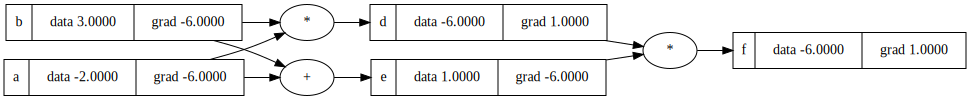

In [17]:
# another faulty case would be
a = Value(-2.0, label = 'a')
b = Value(3.0, label = 'b')
d = a*b; d.label ='d'
e = a+b; e.label ='e'
f = d*e; f.label ='f'

f.backward()
draw_dot(f)

### Hence, anytime if we will use the variable more than once during operations, we will encounter the bug 
The solutiuon is to accumulate the gradient for variables, every time it repeats, instead of reassignment again, as previouly happened.
Hence, use the "self.grad += *** " instead of "self.grad = ** " , in the backward function

### We will correct it in next program